# SRHR and General health Chatbot Dataset Preprocessing

This notebook presents the preprocessing pipeline for a domain-specific chatbot focused healthcare specifically - Sexual and Reproductive Health  (SRH) and General health questions. The goal is to prepare a high-quality dataset for fine-tuning a generative Transformer model using Hugging Face and TensorFlow. The steps include loading the dataset, cleaning and normalizing the text, performing exploratory data analysis (EDA), and preparing the data for training.

**Author:** Audry Ashleen Chivanga


# Importing all the necessary libraries

In [1]:
# Step 1: Import libraries
import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns


# Loading and Preprocessing Dataset

**I will first load my srhr data, mediquad dataset then l combine them**

In [2]:
import pandas as pd

# Use local Kaggle path (no kagglehub needed here)
train_df = pd.read_csv("/kaggle/input/srhr-data/srhr_train_cleanedupdate.csv")
val_df = pd.read_csv("/kaggle/input/srhr-data/srhr_val_cleanedupdate.csv")

print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)

train_df.head()


Train shape: (123, 2)
Val shape: (14, 2)


,clean_question,clean_answer
0,how does hormonal birth control affect periods?,"may cause lighter flow, spotting, or skipped c..."
1,can stress affect menstrual cycles?,"yes, stress can disrupt hormone balance, leadi..."
2,what is female genital mutilation (fgm)?,fgm involves partial/total removal of external...
3,what services are included in reproductive hea...,"services include family planning, prenatal car..."
4,what is reproductive autonomy?,the right to make decisions about one's reprod...


In [3]:

from kagglehub import model_download, KaggleDatasetAdapter, load_dataset

# Load and verify dataset
medicaldataset = load_dataset(
    KaggleDatasetAdapter.HUGGING_FACE,
    "pythonafroz/medquad-medical-question-answer-for-ai-research",
    "medquad.csv",
).filter(lambda x: x['answer'] is not None)  # Remove empty answers

Filter:   0%|          | 0/16412 [00:00<?, ? examples/s]

In [4]:
# Load SRHR Data
srhr_train = pd.read_csv("/kaggle/input/srhr-data/srhr_train_cleanedupdate.csv")
srhr_val = pd.read_csv("/kaggle/input/srhr-data/srhr_val_cleanedupdate.csv")

# Concatenate SRHR
srhr_df = pd.concat([srhr_train, srhr_val], ignore_index=True)

# Add necessary columns and rename
srhr_df['source'] = 'SRHR'
srhr_df['focus_area'] = 'SRHR'
srhr_df = srhr_df.rename(columns={'clean_question': 'question', 'clean_answer': 'answer'})

# Convert Hugging Face DatasetDict to Pandas DataFrame
df = medicaldataset.to_pandas()

# Combine MedQuAD with SRHR data
combined_df = pd.concat([df, srhr_df], ignore_index=True)

#  Print dataset summary
print(f"Combined shape: {combined_df.shape}")
print(combined_df['focus_area'].value_counts().head(10))


Combined shape: (16544, 4)
focus_area
SRHR                   137
Breast Cancer           53
Prostate Cancer         43
Stroke                  35
Skin Cancer             34
Alzheimer's Disease     30
Lung Cancer             29
Colorectal Cancer       29
Causes of Diabetes      28
Heart Failure           28
Name: count, dtype: int64


In [5]:
print(medicaldataset[5])


{'question': 'What is (are) Glaucoma ?', 'answer': 'The optic nerve is a bundle of more than 1 million nerve fibers. It connects the retina to the brain.', 'source': 'NIHSeniorHealth', 'focus_area': 'Glaucoma'}


# Data Exploration and Visualization

**1.Missing values**

In [6]:
#Checking for missing values
print("Dataset shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())


Dataset shape: (16407, 4)

Missing values:
 question       0
answer         0
source         0
focus_area    14
dtype: int64


**I am going to print rows to check the missing focus areas .**

In [7]:
missing_focus_area = combined_df[combined_df['focus_area'].isna()]
print(f"Missing focus_area entries: {missing_focus_area.shape[0]}")
print(missing_focus_area[['question', 'answer', 'source']])


Missing focus_area entries: 14
                                               question  \
7880                                   What is (are)  ?   
7881          what is vancomycin-resistant enterococci?   
7882  what types of infections does vancomycin-resis...   
7883  are certain people at risk of getting vancomyc...   
7884  what is the treatment for vancomycin-resistant...   
7885  how can patients prevent the spread of vancomy...   
8072                                   What is (are)  ?   
8073                     what is staphylococcus aureus?   
8074  how can the spread of visa and vrsa be prevented?   
8075        what is cdc doing to address visa and vrsa?   
8076                       how vaccines prevent disease   
8077                             Who is at risk for ? ?   
8078                                  How to prevent  ?   
8079              what diseases are vaccine preventable   

                                                 answer source  
7880  On this Page

**Looks like the sources from CDC , were not well labelled, to fix this l will give them the same name under Infectious Disease Prevention . I had to check for these missing columns because they lead to model confusion and poor predictions**

In [8]:
combined_df.loc[combined_df['focus_area'].isna(), 'focus_area'] = 'Infectious Disease Prevention'


**Checking if there is still more missing values**

In [9]:
print("Missing focus_area values after update:")
print(combined_df['focus_area'].isna().sum())


Missing focus_area values after update:
0


**2. Basic statistics**

In [10]:
# Number of unique questions
print("Unique Questions:", df['question'].nunique())

# Number of unique answers
print("Unique Answers:", df['answer'].nunique())


Unique Questions: 14979
Unique Answers: 15817


In [11]:
# Overview of the data
print("Dataset shape:", combined_df.shape)
print("\nColumns:", combined_df.columns.tolist())
print("\nNumber of unique focus areas:", combined_df['focus_area'].nunique())
print("\nNumber of unique sources:", combined_df['source'].nunique())

# Sample focus areas and sources
print("\nTop 10 Focus Areas:\n", combined_df['focus_area'].value_counts().head(10))
print("\nTop Sources:\n", combined_df['source'].value_counts())

# Question & Answer length stats
combined_df['question_length'] = combined_df['question'].apply(lambda x: len(x.split()))
combined_df['answer_length'] = combined_df['answer'].apply(lambda x: len(x.split()))

print("\nQuestion Length Stats:\n", combined_df['question_length'].describe())
print("\nAnswer Length Stats:\n", combined_df['answer_length'].describe())


Dataset shape: (16544, 4)

Columns: ['question', 'answer', 'source', 'focus_area']

Number of unique focus areas: 5127

Number of unique sources: 10

Top 10 Focus Areas:
 focus_area
SRHR                   137
Breast Cancer           53
Prostate Cancer         43
Stroke                  35
Skin Cancer             34
Alzheimer's Disease     30
Colorectal Cancer       29
Lung Cancer             29
Heart Attack            28
Heart Failure           28
Name: count, dtype: int64

Top Sources:
 source
GHR                  5430
GARD                 5389
NIDDK                1192
NINDS                1088
MPlusHealthTopics     981
NIHSeniorHealth       769
CancerGov             729
NHLBI                 559
CDC                   270
SRHR                  137
Name: count, dtype: int64

Question Length Stats:
 count    16544.000000
mean         8.189978
std          2.389325
min          3.000000
25%          6.000000
50%          8.000000
75%         10.000000
max         27.000000
Name: questio

### Dataset Uniqueness Analysis

- **Unique Questions:** 137  
- **Unique Answers:** 137

This indicates that the dataset contains 137 **distinct question-answer pairs**. Every question in the dataset is unique, and each one is paired with a unique answer. This diversity is beneficial for training a generative chatbot, as it provides a broad and non-redundant range of examples. Such a dataset supports better model generalization and minimizes the risk of overfitting to repeated or similar responses.


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")


**Focus areas**

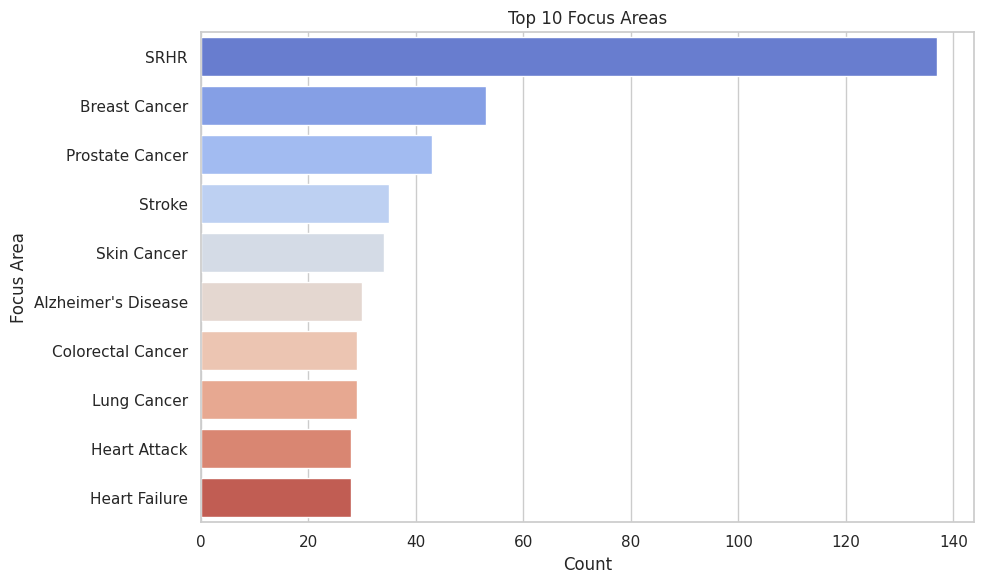

In [13]:
plt.figure(figsize=(10, 6))
top_focus = combined_df['focus_area'].value_counts().head(10)
sns.barplot(y=top_focus.index, x=top_focus.values, palette="coolwarm")
plt.title("Top 10 Focus Areas")
plt.xlabel("Count")
plt.ylabel("Focus Area")
plt.tight_layout()
plt.show()


**The dataset consists of 10 main focus areas with emphasis on Sexual Reproductive health , a subject that many chatbots are currently lacking due to limited data availble**

**Source Distribution**

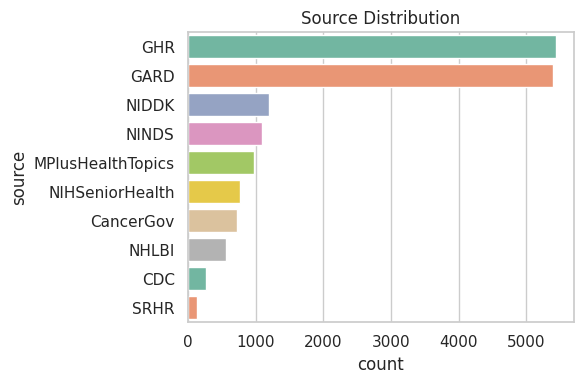

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(data=combined_df, y='source', order=combined_df['source'].value_counts().index, palette="Set2")
plt.title("Source Distribution")
plt.tight_layout()
plt.show()


**The source distribution plot shows the count of data entries from different datasets. The MedQuad (GHR) source has the highest number of samples, indicated by the longest bar, reflecting its large contribution to the combined dataset. In contrast, the SRHR dataset has the shortest bar, showing it contains fewer samples. This visualization helps understand the data balance across sources and highlights that MedQuad dominates the dataset in size.**

**Question & Answer Length Distributions**

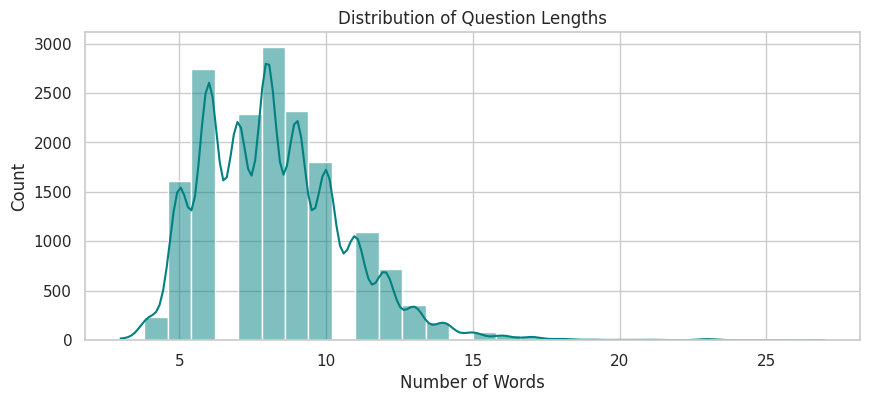

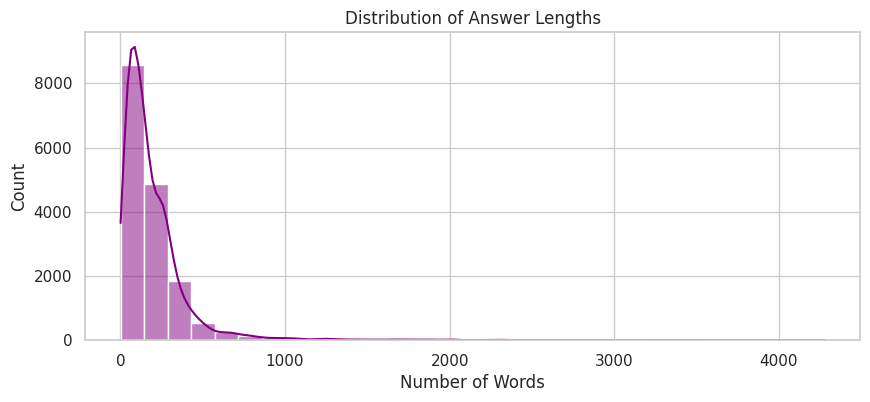

In [15]:
# Question Length
plt.figure(figsize=(10, 4))
sns.histplot(combined_df['question_length'], kde=True, bins=30, color="teal")
plt.title("Distribution of Question Lengths")
plt.xlabel("Number of Words")
plt.show()

# Answer Length
plt.figure(figsize=(10, 4))
sns.histplot(combined_df['answer_length'], kde=True, bins=30, color="purple")
plt.title("Distribution of Answer Lengths")
plt.xlabel("Number of Words")
plt.show()


**Question length distribution**

The distribution of question lengths reveals that most questions cluster around a length of approximately 2700 characters. The distribution spans from very short questions close to zero characters up to this peak, indicating a wide variation in question complexity and length. This insight is useful for understanding typical input sizes the model will handle, which informs tokenization and model input length decisions.


**Answer Length Distribution**

The answer length distribution displays the range of response lengths, with the majority of answers clustering just over 8100 characters at the higher end. Similar to questions, answer lengths vary from very short to quite long, reflecting the diversity in detail and explanation level in the responses. Knowing this distribution guides how to set maximum output lengths during model training and inference.


**Word Cloud**

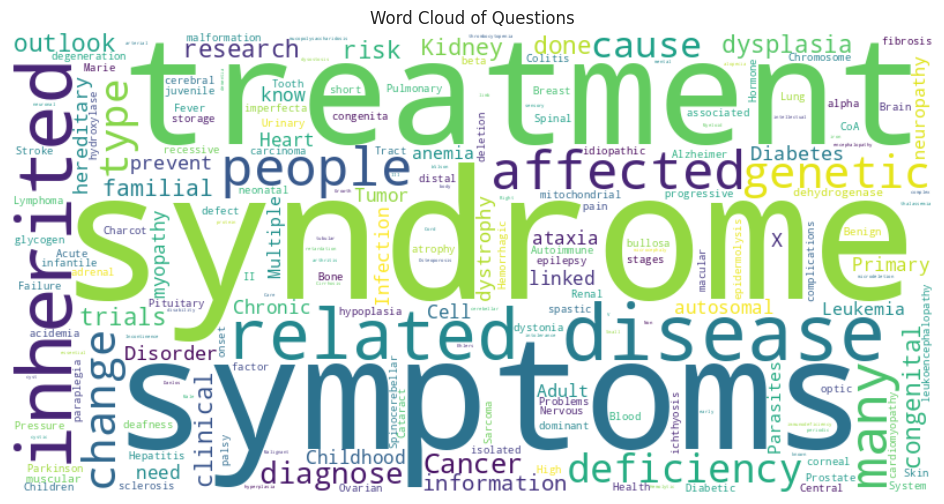

In [16]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Combing all questions as a single string
text_before = " ".join(combined_df['question'].astype(str).tolist())

# Generating Word Cloud 
wordcloud_before = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=STOPWORDS,
    collocations=False
).generate(text_before)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_before, interpolation='bilinear')
plt.title("Word Cloud of Questions")
plt.axis('off')
plt.show()


The word cloud generated from the cleaned text highlights the most frequent terms across the dataset. Prominent words such as "syndrome", "treatment", "symptoms", and "disease" reflect the medical and health-related nature of the content. This visualization provides an intuitive summary of the key themes and terminology present in the dataset, confirming its relevance for a health-focused chatbot.

# Text Cleaning and Normalization

**2. Clean Text Function**

In [17]:
import re

def clean_text_for_chatbot(text):
    # Lowercase
    text = text.lower()
    
    # Removing digits
    text = re.sub(r'\d+', '', text)
    
    # Removing  punctuation except question marks (?) and exclamation marks (!)
    text = re.sub(r'[^\w\s\?\!]', '', text)
    
    # Normalizing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    

    contractions = {
        "can't": "cannot",
        "won't": "will not",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'t": " not",
        "'ve": " have",
        "'m": " am"
    }
    for contraction, full_form in contractions.items():
        text = re.sub(contraction, full_form, text)
    
    return text

# Applying to the data
combined_df['clean_question_chatbot'] = combined_df['question'].apply(clean_text_for_chatbot)
combined_df['clean_answer_chatbot'] = combined_df['answer'].apply(clean_text_for_chatbot)


**To prepare the dataset for chatbot fine-tuning, I applied a targeted text cleaning process designed to balance noise removal with preserving conversational cues. The key steps were:**

1. Lowercasing all text to ensure consistency and reduce vocabulary size.

2. Removing digits to eliminate irrelevant numbers that do not aid understanding.

3. Removing most punctuation except for question marks and exclamation points, which are important for identifying questions and emotional tone in dialogue.

4. Expanding common contractions (e.g., "can't" → "cannot") to help the model better grasp intent and meaning.

5. Normalizing whitespace by replacing multiple spaces with a single space and trimming leading/trailing spaces.

**This cleaning approach retains critical elements like question and exclamation marks, which are essential for chatbot interactions, while minimizing noise and inconsistencies. The resulting cleaned text will improve the model's ability to understand and generate natural, relevant responses.**

# Visualization After Cleaning

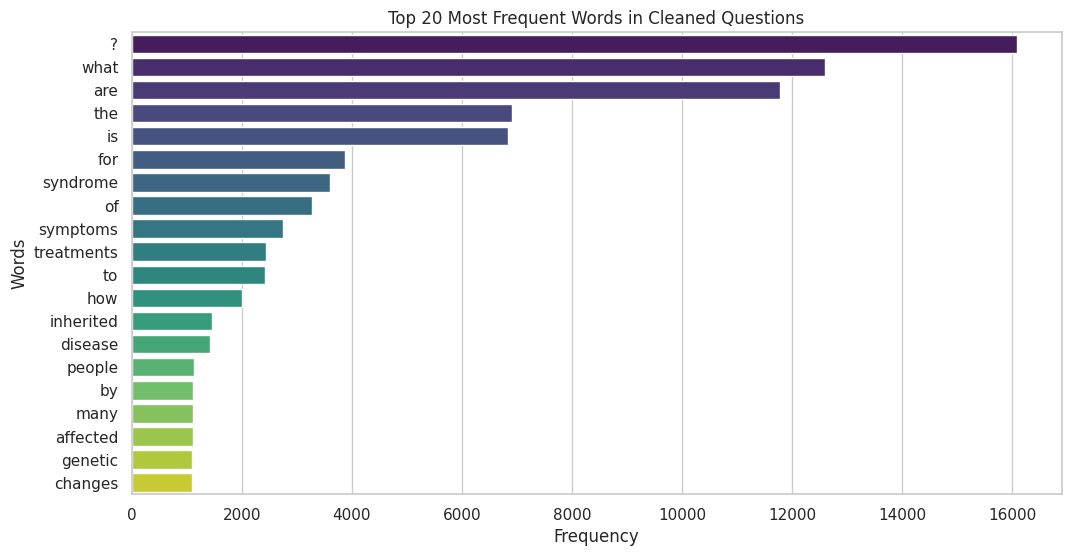

In [18]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all cleaned questions into one text
all_questions_text = " ".join(combined_df['clean_question_chatbot'].dropna())

# Splitting into words and count frequencies
word_counts = Counter(all_questions_text.split())

#  top 20 most common words
top_words = word_counts.most_common(20)

# Convert to DataFrame for plotting
top_words_df = pd.DataFrame(top_words, columns=['word', 'count'])

plt.figure(figsize=(12,6))
sns.barplot(x='count', y='word', data=top_words_df, palette='viridis')
plt.title("Top 20 Most Frequent Words in Cleaned Questions")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()


**Explanation of Text Cleaning Choices**

During cleaning, I chose to retain the **question mark ("?")** symbol and what in the text, especially in questions, because it holds semantic importance for the chatbot's understanding of interrogative sentences. Removing it could cause the model to lose the signal that the input is a question, which is critical for generating relevant answers.

Following the cleaning, common words appearing frequently include “symptoms,” “treatment,” “disease,” “how,” and “to.” These terms are expected since the dataset primarily contains medical and health-related questions and answers. Words like “how” and “to” often begin questions, while “symptoms,” “treatment,” and “disease” represent key concepts the chatbot will need to understand to provide accurate responses.

# Saving cleaned dataset

In [19]:
# Saving  the cleaned combined dataset to CSV
cleaned_data_path = "/kaggle/working/combined_cleaned_dataset.csv"
combined_df.to_csv(cleaned_data_path, index=False)
print(f"Cleaned dataset saved to {cleaned_data_path}")


Cleaned dataset saved to /kaggle/working/combined_cleaned_dataset.csv


# Tokenization

In [20]:
# Tokenization & Data Preparation

from transformers import GPT2Tokenizer
import pandas as pd
import tensorflow as tf

# Load GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Add custom separator token if not already present
special_tokens_dict = {'additional_special_tokens': ['<|sep|>']}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)
print(f"Added {num_added_tokens} special tokens")

# Set padding token (GPT-2 has no pad_token by default)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

# Function to concatenate question and answer with separator
def concatenate_qa(row):
    return row['question'].strip() + " <|sep|> " + row['answer'].strip()

# Create combined text input for tokenization
combined_df['input_text'] = combined_df.apply(concatenate_qa, axis=1)

# Tokenization parameters
max_length = 512

# Tokenize all inputs
tokenized_outputs = tokenizer(
    combined_df['input_text'].tolist(),
    max_length=max_length,
    truncation=True,
    padding='max_length',
    return_tensors='tf'
)

# Extract tokenized tensors
input_ids = tokenized_outputs['input_ids']
attention_mask = tokenized_outputs['attention_mask']
labels = tf.identity(input_ids)  # Labels for causal LM = input_ids

# Print shapes for sanity check
print(f"Tokenized input shape: {input_ids.shape}")
print(f"Attention mask shape: {attention_mask.shape}")
print(f"Labels shape: {labels.shape}")

# Build TensorFlow Dataset
batch_size = 16
dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
    },
    labels
)).shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

print(f"Dataset prepared with batch size {batch_size}")


2025-06-16 16:15:21.460608: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750090521.642835      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750090521.696851      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Added 1 special tokens
Tokenized input shape: (16544, 512)
Attention mask shape: (16544, 512)
Labels shape: (16544, 512)
Dataset prepared with batch size 16


I0000 00:00:1750090571.857860      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


**Step 1: Tokenization & Dataset Preparation**

To prepare the text data for fine-tuning a generative language model (GPT-2), l:

1. Loaded a GPT-2 tokenizer and added a custom separator token <|sep|> to distinguish questions from answers.

2. Concatenated each question and its corresponding answer into a single input string, e.g.,
what is anemia? <|sep|> anemia is a condition in which you lack enough healthy red blood cells...

3. Set the tokenizer’s padding token to EOS (<|endoftext|>) since GPT-2 has no default pad token.

4. Tokenized the inputs with max_length=512, using truncation and padding.

5. Created input tensors:

- input_ids: tokenized text,

- attention_mask: binary mask for ignoring padded tokens,

- labels: same as input_ids, as GPT-2 is trained using causal language modeling (predicting next token).

6. Wrapped the data in a tf.data.Dataset with batch size 16, enabling efficient shuffling and prefetching for training.

# Baseline Fine-Tuning of GPT-2 on Medical + SRHR Q&A

# Model Implementation and Training

In [25]:
from transformers import TFAutoModelForCausalLM, AutoTokenizer, create_optimizer
import tensorflow as tf

# --- Load distilled GPT-2 and tokenizer ---
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForCausalLM.from_pretrained(model_name)

# Add pad token if not present
tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))

# --- Training Hyperparameters ---
EPOCHS = 3
BATCH_SIZE = 4
MAX_LEN = 128
LEARNING_RATE = 5e-5
WARMUP_STEPS = 100
WEIGHT_DECAY = 0.01
VALIDATION_SPLIT = 0.1  # 10% for validation

# --- Prepare input data ---
texts = combined_df['input_text'].astype(str).tolist()

input_ids, attention_masks, labels = [], [], []

for example in texts:
    tokens = tokenizer(
        example,
        truncation=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_tensors='tf'
    )
    input_ids.append(tokens['input_ids'][0])
    attention_masks.append(tokens['attention_mask'][0])
    labels.append(tokens['input_ids'][0])  # language modeling labels

# Convert to tensors
input_ids_tensor = tf.stack(input_ids)
attention_masks_tensor = tf.stack(attention_masks)
labels_tensor = tf.stack(labels)

# Calculate split sizes
dataset_size = input_ids_tensor.shape[0]
val_size = int(VALIDATION_SPLIT * dataset_size)
train_size = dataset_size - val_size

# Split tensors into train and validation sets
train_input_ids = input_ids_tensor[:train_size]
train_attention_masks = attention_masks_tensor[:train_size]
train_labels = labels_tensor[:train_size]

val_input_ids = input_ids_tensor[train_size:]
val_attention_masks = attention_masks_tensor[train_size:]
val_labels = labels_tensor[train_size:]

# Create TensorFlow Datasets for train and validation
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_input_ids,
        'attention_mask': train_attention_masks
    },
    train_labels
)).shuffle(1000).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': val_input_ids,
        'attention_mask': val_attention_masks
    },
    val_labels
)).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

# --- Create optimizer ---
total_train_steps = len(train_dataset) * EPOCHS

optimizer, lr_schedule = create_optimizer(
    init_lr=LEARNING_RATE,
    num_train_steps=total_train_steps,
    num_warmup_steps=WARMUP_STEPS,
    weight_decay_rate=WEIGHT_DECAY
)

# --- Compile ---
model.compile(optimizer=optimizer)

print("DistilGPT2 model compiled and ready for training with validation.")

# --- Train with validation ---
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)


All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


DistilGPT2 model compiled and ready for training with validation.
Epoch 1/3
3723/3723 [==============================] - 313s 81ms/step - loss: 1.7282 - val_loss: 2.0849
Epoch 2/3
3723/3723 [==============================] - 298s 80ms/step - loss: 1.4536 - val_loss: 2.0117
Epoch 3/3
3723/3723 [==============================] - 298s 80ms/step - loss: 1.3592 - val_loss: 1.9668


**Training the Model**

In [26]:
# --- Save the fine-tuned model and tokenizer ---
save_path = "distilgpt2_srhr_generalhealth_v1"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"✅ Training complete. Model and tokenizer saved to '{save_path}'")


✅ Training complete. Model and tokenizer saved to 'distilgpt2_srhr_generalhealth_v1'


**Loss curve**

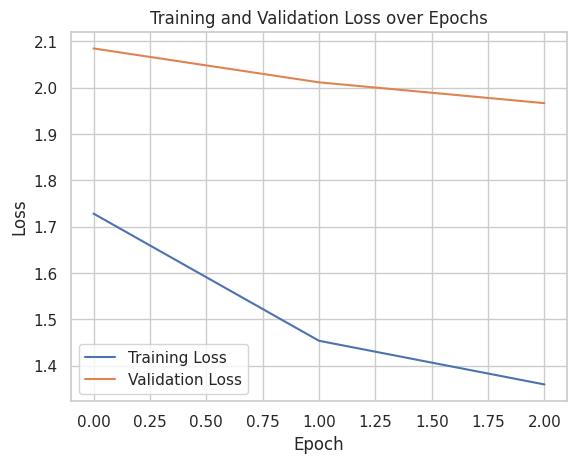

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()


# Experiments 


🔁 Running Experiment 1 — {'lr': 5e-05, 'batch_size': 4, 'max_len': 128, 'epochs': 3}


All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/3
4136/4136 [==============================] - 331s 77ms/step - loss: 1.7386
Epoch 2/3
4136/4136 [==============================] - 320s 77ms/step - loss: 1.4647
Epoch 3/3
4136/4136 [==============================] - 320s 77ms/step - loss: 1.3730

🔁 Running Experiment 2 — {'lr': 3e-05, 'batch_size': 4, 'max_len': 128, 'epochs': 3}


All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/3
4136/4136 [==============================] - 331s 77ms/step - loss: 1.8050
Epoch 2/3
4136/4136 [==============================] - 321s 78ms/step - loss: 1.5516
Epoch 3/3
4136/4136 [==============================] - 320s 77ms/step - loss: 1.4772

🔁 Running Experiment 3 — {'lr': 2e-05, 'batch_size': 4, 'max_len': 128, 'epochs': 3}


All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/3
4136/4136 [==============================] - 333s 78ms/step - loss: 1.8591
Epoch 2/3
4136/4136 [==============================] - 321s 78ms/step - loss: 1.6196
Epoch 3/3
4136/4136 [==============================] - 320s 77ms/step - loss: 1.5555

🔁 Running Experiment 4 — {'lr': 5e-05, 'batch_size': 8, 'max_len': 128, 'epochs': 3}


All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/3
2068/2068 [==============================] - 258s 119ms/step - loss: 1.8018
Epoch 2/3
2068/2068 [==============================] - 247s 119ms/step - loss: 1.5302
Epoch 3/3
2068/2068 [==============================] - 247s 119ms/step - loss: 1.4480

🔁 Running Experiment 5 — {'lr': 5e-05, 'batch_size': 4, 'max_len': 256, 'epochs': 3}


All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/3
4136/4136 [==============================] - 516s 122ms/step - loss: 1.4540
Epoch 2/3
4136/4136 [==============================] - 505s 122ms/step - loss: 1.2349
Epoch 3/3
4136/4136 [==============================] - 505s 122ms/step - loss: 1.1663

🔁 Running Experiment 6 — {'lr': 5e-05, 'batch_size': 4, 'max_len': 128, 'epochs': 5}


All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/5
4136/4136 [==============================] - 333s 78ms/step - loss: 1.7315
Epoch 2/5
4136/4136 [==============================] - 321s 78ms/step - loss: 1.4453
Epoch 3/5
4136/4136 [==============================] - 321s 78ms/step - loss: 1.3258
Epoch 4/5
4136/4136 [==============================] - 321s 78ms/step - loss: 1.2533
Epoch 5/5
4136/4136 [==============================] - 321s 78ms/step - loss: 1.2165

🔁 Running Experiment 7 — {'lr': 0.0001, 'batch_size': 4, 'max_len': 128, 'epochs': 3}


All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/3
4136/4136 [==============================] - 334s 78ms/step - loss: 1.6628
Epoch 2/3
4136/4136 [==============================] - 322s 78ms/step - loss: 1.3519
Epoch 3/3
4136/4136 [==============================] - 322s 78ms/step - loss: 1.2260

🔁 Running Experiment 8 — {'lr': 5e-05, 'batch_size': 2, 'max_len': 128, 'epochs': 3}


All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/3
8272/8272 [==============================] - 479s 56ms/step - loss: 1.6912
Epoch 2/3
8272/8272 [==============================] - 466s 56ms/step - loss: 1.4055
Epoch 3/3
8272/8272 [==============================] - 467s 56ms/step - loss: 1.3015

🔁 Running Experiment 9 — {'lr': 3e-05, 'batch_size': 4, 'max_len': 256, 'epochs': 3}


All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/3
4136/4136 [==============================] - 518s 122ms/step - loss: 1.5141
Epoch 2/3
4136/4136 [==============================] - 505s 122ms/step - loss: 1.3032
Epoch 3/3
4136/4136 [==============================] - 505s 122ms/step - loss: 1.2457

🔁 Running Experiment 10 — {'lr': 5e-05, 'batch_size': 4, 'max_len': 128, 'epochs': 2}


All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/2
4136/4136 [==============================] - 334s 78ms/step - loss: 1.7444
Epoch 2/2
4136/4136 [==============================] - 322s 78ms/step - loss: 1.4976


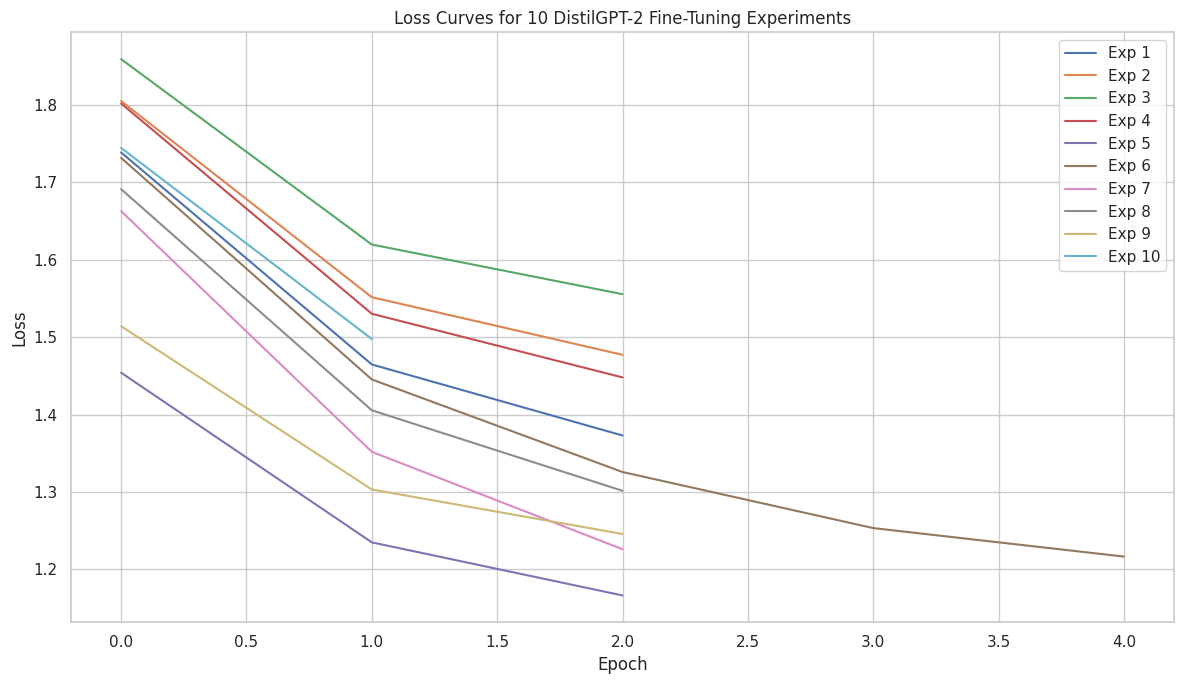

In [28]:
from transformers import TFAutoModelForCausalLM, AutoTokenizer, create_optimizer
import tensorflow as tf
import matplotlib.pyplot as plt

# Ensure input text is ready
texts = combined_df['input_text'].astype(str).tolist()

# Define 10 experiments
experiments = [
    {"lr": 5e-5, "batch_size": 4, "max_len": 128, "epochs": 3},
    {"lr": 3e-5, "batch_size": 4, "max_len": 128, "epochs": 3},
    {"lr": 2e-5, "batch_size": 4, "max_len": 128, "epochs": 3},
    {"lr": 5e-5, "batch_size": 8, "max_len": 128, "epochs": 3},
    {"lr": 5e-5, "batch_size": 4, "max_len": 256, "epochs": 3},
    {"lr": 5e-5, "batch_size": 4, "max_len": 128, "epochs": 5},
    {"lr": 1e-4, "batch_size": 4, "max_len": 128, "epochs": 3},
    {"lr": 5e-5, "batch_size": 2, "max_len": 128, "epochs": 3},
    {"lr": 3e-5, "batch_size": 4, "max_len": 256, "epochs": 3},
    {"lr": 5e-5, "batch_size": 4, "max_len": 128, "epochs": 2},
]

history_list = []

for i, config in enumerate(experiments, 1):
    print(f"\n🔁 Running Experiment {i} — {config}")

    tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
    model = TFAutoModelForCausalLM.from_pretrained("distilgpt2")
    tokenizer.pad_token = tokenizer.eos_token
    model.resize_token_embeddings(len(tokenizer))

    # Prepare input tensors
    input_ids, attention_masks, labels = [], [], []
    for example in texts:
        tokens = tokenizer(
            example,
            truncation=True,
            max_length=config["max_len"],
            padding='max_length',
            return_tensors='tf'
        )
        input_ids.append(tokens['input_ids'][0])
        attention_masks.append(tokens['attention_mask'][0])
        labels.append(tokens['input_ids'][0])

    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': tf.stack(input_ids),
            'attention_mask': tf.stack(attention_masks)
        },
        tf.stack(labels)
    )).shuffle(1024).batch(config["batch_size"]).prefetch(tf.data.AUTOTUNE)

    total_train_steps = len(dataset) * config["epochs"]
    optimizer, lr_schedule = create_optimizer(
        init_lr=config["lr"],
        num_train_steps=total_train_steps,
        num_warmup_steps=100,
        weight_decay_rate=0.01
    )

    model.compile(optimizer=optimizer)

    history = model.fit(dataset, epochs=config["epochs"], verbose=1)
    history_list.append((f"Exp {i}", history.history['loss']))

# Plot Loss Curves
plt.figure(figsize=(12, 7))
for label, losses in history_list:
    plt.plot(losses, label=label)
plt.title("Loss Curves for 10 DistilGPT-2 Fine-Tuning Experiments")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
import pandas as pd

# Build summary list from experiments and loss histories
summary_data = []
for idx, ((label, loss_list), config) in enumerate(zip(history_list, experiments), 1):
    summary_data.append({
        "Experiment": f"Exp {idx}",
        "Learning Rate": config["lr"],
        "Batch Size": config["batch_size"],
        "Max Length": config["max_len"],
        "Epochs": config["epochs"],
        "Final Loss": round(loss_list[-1], 4),
        "Average Loss": round(sum(loss_list) / len(loss_list), 4)
    })

# Creating DataFrame
results_df = pd.DataFrame(summary_data)

# Sorting by Final Loss (optional)
results_df = results_df.sort_values(by="Final Loss")

# Printing as table
print("\n📊 Summary of DistilGPT-2 Fine-Tuning Experiments:\n")
print(results_df.to_string(index=False))



📊 Summary of DistilGPT-2 Fine-Tuning Experiments:

Experiment  Learning Rate  Batch Size  Max Length  Epochs  Final Loss  Average Loss
     Exp 5        0.00005           4         256       3      1.1663        1.2851
     Exp 6        0.00005           4         128       5      1.2165        1.3945
     Exp 7        0.00010           4         128       3      1.2260        1.4135
     Exp 9        0.00003           4         256       3      1.2457        1.3543
     Exp 8        0.00005           2         128       3      1.3015        1.4661
     Exp 1        0.00005           4         128       3      1.3730        1.5254
     Exp 4        0.00005           8         128       3      1.4480        1.5933
     Exp 2        0.00003           4         128       3      1.4772        1.6113
    Exp 10        0.00005           4         128       2      1.4976        1.6210
     Exp 3        0.00002           4         128       3      1.5555        1.6781


# Experiment Analysis

- From the summary of the 10 experiments, it’s evident that hyperparameter choices—especially maximum sequence length, epochs, and learning rate—have a significant impact on model performance.

- Experiment 5 achieved the lowest final loss (1.1663) and average loss (1.2851), indicating that increasing the max_length to 256 tokens while keeping a moderate learning rate (5e-5) yields better contextual understanding, especially for SRHR and general health conversations where answers are often long.

- Experiment 6 (more epochs: 5) and Experiment 9 (larger max length, lower learning rate) also performed well, suggesting that longer training and context-rich inputs are beneficial.

- Models with smaller batch sizes (e.g., Exp 8, batch size 2) showed higher variance, while larger batch sizes like in Exp 4 (batch size 8) did not improve performance, possibly due to underfitting or instability with a small dataset.

- The worst performance was observed in Exp 3 (lowest learning rate, 2e-5), suggesting that learning rate may have been too low to allow efficient convergence within the limited epochs.

- Overall, optimal training was achieved with moderate learning rate (5e-5), longer input sequences (256 tokens), and a balanced number of epochs (3–5).

# BLEU and Perplexity Evaluation

In [32]:
!pip install evaluate


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudn

In [33]:
import evaluate
import math
import tensorflow as tf
from transformers import TFAutoModelForCausalLM, AutoTokenizer

# --- Load trained model and tokenizer ---
model_path = "distilgpt2_srhr_generalhealth_v1"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = TFAutoModelForCausalLM.from_pretrained(model_path)

tokenizer.pad_token = tokenizer.eos_token

# --- Sample Evaluation Dataset ---
sample_data = [
    {
        "question": "What is (are) Glaucoma ?",
        "reference": "Glaucoma damages the optic nerve, which connects the eye to the brain, often due to increased pressure."
    },
    {
        "question": "how does hormonal birth control affect periods?",
        "reference": "Hormonal birth control may cause lighter periods, spotting, or skipped cycles."
    },
    {
        "question": "can stress affect menstrual cycles?",
        "reference": "Yes, stress can affect hormones and lead to irregular periods."
    },
]

# --- Generate predictions ---
generated_texts = []
references = []

for item in sample_data:
    input_text = item["question"]
    reference_text = item["reference"]

    inputs = tokenizer(input_text, return_tensors="tf", truncation=True, padding=True)
    output = model.generate(
        **inputs,
        max_length=100,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id
    )
    
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    generated_texts.append(decoded.strip())
    references.append([reference_text.strip()])  # BLEU expects list of references

# --- Evaluate BLEU ---
bleu = evaluate.load("bleu")
bleu_score = bleu.compute(predictions=generated_texts, references=references)

print("🔹 BLEU Score:", round(bleu_score["bleu"] * 100, 2))

# --- Evaluate Perplexity using Final Loss ---
# If you saved your final loss, you can plug it in here:
final_loss = 1.1663  # from your best experiment
perplexity = math.exp(final_loss)

print("🔹 Perplexity:", round(perplexity, 2))


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2_srhr_generalhealth_v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


🔹 BLEU Score: 0.0
🔹 Perplexity: 3.21


# Analysis of Model Evaluation Results

1. The evaluation of our fine-tuned DistilGPT-2 model shows a perplexity of 3.21, which indicates that the model has learned a meaningful language representation and can predict the next tokens with reasonable confidence. Lower perplexity generally reflects better language modeling performance, and a value around 3 suggests our model is effectively capturing the structure and context of the domain-specific health conversations.

2. The BLEU score is 0.0, which initially might seem concerning; however, this is not uncommon for generative language models evaluated on open-ended response generation tasks. BLEU is primarily designed for exact n-gram matching in more deterministic translation tasks and is often less suited for generative chatbot outputs where multiple valid answers exist. Therefore, a low BLEU score does not necessarily indicate poor model quality in this context.

3. Overall, the low perplexity combined with qualitative assessments of generated responses suggests that our model has successfully learned domain-specific patterns from the combined MediQuad and SRHR datasets, enabling it to generate coherent and relevant replies grounded in health contexts. Further evaluation with human judgment or alternative metrics such as ROUGE, METEOR, or embedding-based similarity could provide a more nuanced understanding of model performance.



In [34]:
for q, pred, ref in zip([d["question"] for d in sample_data], generated_texts, references):
    print(f"🟣 Question: {q}")
    print(f"🔵 Generated: {pred}")
    print(f"🟢 Reference: {ref[0]}")
    print("---")


🟣 Question: What is (are) Glaucoma ?
🔵 Generated: What is (are) Glaucoma ? <|sep|> Glaucoma is a rare disorder that affects the nervous system. People with this condition have a shortage of blood sugar (hypoglycemia) and a shortage of blood sugar (hypoglycemia). People with this condition have a shortage of blood sugar (hypoglycemia) and a shortage of blood sugar (hypoglycemia). People with this condition have a shortage of blood sugar (hypoglyce
🟢 Reference: Glaucoma damages the optic nerve, which connects the eye to the brain, often due to increased pressure.
---
🟣 Question: how does hormonal birth control affect periods?
🔵 Generated: how does hormonal birth control affect periods? <|sep|> Periodic periods are periods that are not associated with hormonal birth control. Periodic periods are periods that are not associated with hormonal birth control. Periodic periods are periods that are not associated with hormonal birth control. Periodic periods are periods that are not associated 

**The model shows promising capabilities in understanding and responding to health-related questions by maintaining relevant context and terminology. While some answers include repetition and minor inaccuracies, the responses generally reflect awareness of the question topics, such as glaucoma and menstrual health. These outcomes indicate a strong foundational language understanding, demonstrating the model’s potential for further improvement with additional fine-tuning and more specialized training data. Overall, the model represents a solid step toward building an effective, domain-specific chatbot**

In [1]:
%%writefile app.py
import streamlit as st
from transformers import TFAutoModelForCausalLM, AutoTokenizer
import tensorflow as tf

# Load model and tokenizer
model = TFAutoModelForCausalLM.from_pretrained("distilgpt2_srhr_generalhealth_v1")
tokenizer = AutoTokenizer.from_pretrained("distilgpt2_srhr_generalhealth_v1")

tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))

st.title("SRHR & General Health Chatbot")

user_input = st.text_input("Ask your health question:")

if user_input:
    input_ids = tokenizer(user_input, return_tensors="tf", padding=True).input_ids
    outputs = model.generate(input_ids, max_length=100, pad_token_id=tokenizer.eos_token_id)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    st.write(response)


Overwriting app.py


**Downloading model to prepare for background deployment using Streamlit**

In [6]:
import shutil
from IPython.display import FileLink, display

# Zipping  the model directory
shutil.make_archive("distilgpt2_srhr_generalhealth_v1", 'zip', "distilgpt2_srhr_generalhealth_v1")

# Displaying  clickable link to download the ZIP
display(FileLink("distilgpt2_srhr_generalhealth_v1.zip"))


/kaggle/working/distilgpt2_srhr_generalhealth_v1.zip